In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb


In [3]:
df = pd.read_csv('crash_data_queensland_e_alcohol_speed_fatigue_defect.csv')

In [4]:
df['Crash_Severity'] = df["Crash_Severity"].map({"Fatal" : 1, "Non-Fatal" : 0}).fillna(0)

In [5]:
X = df[['Involving_Drink_Driving','Involving_Driver_Speed','Involving_Fatigued_Driver','Involving_Defective_Vehicle']].applymap(lambda x:1 if x=='Yes' else 0)
y = df['Crash_Severity']

/var/folders/zl/kpxqgqsj4y77_m2_yd8kmg2m0000gn/T/ipykernel_53336/587030255.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = df[['Involving_Drink_Driving','Involving_Driver_Speed','Involving_Fatigued_Driver','Involving_Defective_Vehicle']].applymap(lambda x:1 if x=='Yes' else 0)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
xgb_model = xgb.XGBClassifier(use_label_encoder = False, eval_metrics = "logloss")
xgb_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:39:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
pred_y = xgb_model.predict(X_test)

In [9]:
acc = accuracy_score(y_test , pred_y)
rep = classification_report(y_test, pred_y)
print(f"Accuaracy: ", {acc})
print('Classification report:')
print(f'{rep}')

Accuaracy:  {0.8263888888888888}
Classification report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.90      1190
         1.0       0.00      0.00      0.00       250

    accuracy                           0.83      1440
   macro avg       0.41      0.50      0.45      1440
weighted avg       0.68      0.83      0.75      1440



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [11]:
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Crash_Severity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     16.62
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           1.71e-13
Time:                        19:45:23   Log-Likelihood:                -1437.2
No. Observations:                3359   AIC:                             2884.
Df Residuals:                    3354   BIC:                             2915.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

/var/folders/zl/kpxqgqsj4y77_m2_yd8kmg2m0000gn/T/ipykernel_53336/236992232.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


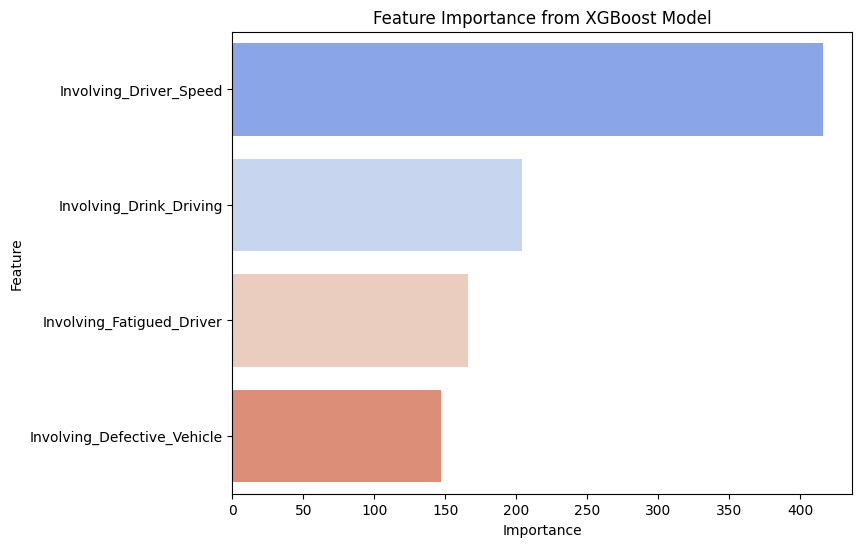

In [12]:
# Get feature importance from the XGBoost model
importance = xgb_model.get_booster().get_score(importance_type='weight')

# Convert feature importance into a DataFrame
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance from XGBoost Model')
plt.show()


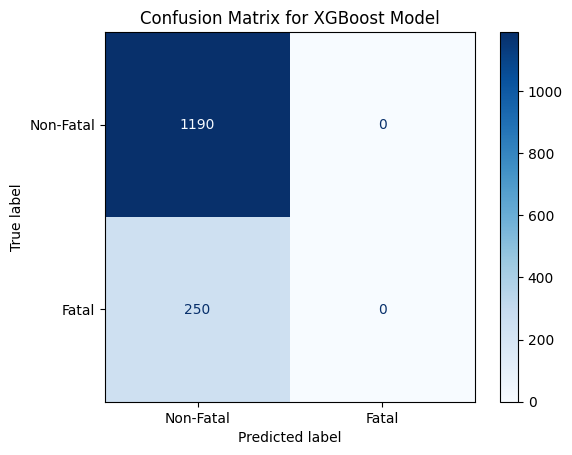

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, pred_y)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fatal', 'Fatal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Model')
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Grid search
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                           param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
""

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [19:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src

''